In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from tqdm import tqdm

from spluslib import SplusService, ImageType
from xmatchlib import XTable, CrossMatch

In [24]:
def create_spec_tables(clusters):
  df_spec = pd.read_csv('SpecZ_Catalogue_20230830.csv')
  paths = [Path(f'outputs/cluster_{c}.csv') for c in clusters]
  
  for path in tqdm(paths):
    xt_base = XTable(ra='RA', dec='DEC', path=path)
    xt_spec = XTable(ra='RA', dec='DEC', df=df_spec[df_spec['z'] < 0.1])
    
    cm = CrossMatch()
    match = cm.crossmatch(xt_base, xt_spec, radius=1)
    match.table.to_csv(Path('outputs') / (path.stem + '_spec.csv'), index=False)
    
    
    
def download_cluster_cat(cluster_map):
  query_template = """
  SELECT dual_g.ID, dual_g.RA, dual_g.DEC, dual_g.Field, 
        dual_g.g_auto, dual_r.r_auto, dual_i.i_auto, dual_r.r_aper_6,
        photoz.zml, photoz.odds, morpho.PROB_GAL, '{cluster}' AS cluster
  FROM
  idr4_dual_g AS dual_g
  INNER JOIN
  idr4_dual_i AS dual_i ON dual_i.ID = dual_g.ID
  INNER JOIN
  idr4_dual_r AS dual_r ON dual_r.ID = dual_g.ID
  INNER JOIN
  idr4_photoz AS photoz ON photoz.ID = dual_g.ID
  INNER JOIN
  idr4_star_galaxy_quasar AS morpho ON morpho.ID = dual_g.ID
  WHERE
  dual_g.Field IN ({fields})
  """

  queries = [
    query_template.format(cluster=key, fields="'" + "','".join(value) + "'") 
    for key, value in cluster_map.items()
  ]
  
  print(queries[0])

  sp = SplusService(username='natanael', password='natan')
  save_paths = [Path('outputs') / f'cluster_{c}.csv' for c in cluster_map.keys()]
  sp.batch_query(sql=queries, save_path=save_paths, replace=True, scope='private', workers=4)
  
  
def concat_tables(paths, save_path):
  df = pd.read_csv(paths[0])
  
  for i in tqdm(range(1, len(paths))):
    df2 = pd.read_csv(paths[i])
    df = pd.concat((df, df2), ignore_index=True)
  
  df = df[df.columns.drop(list(df.filter(regex='Unnamed:*')))]
  df.to_csv(save_path, index=False)

In [6]:
dfe = pd.read_csv('Tiles_for_Erik_clean.csv')
dfe['available'] = dfe['available'].replace('False ', 'False')
dfe['available'] = dfe['available'].replace('True ', 'True')
dfe['NAME'] = dfe['NAME'].str.replace('_', '-')
dfe = dfe[dfe['available'] == 'True']
clusters = dfe['CLS_ID'].unique()
cluster_map = {c: dfe[dfe['CLS_ID'] == c]['NAME'].to_list() for c in clusters}

download_cluster_cat(cluster_map)
create_spec_tables(clusters)


  SELECT dual_g.ID, dual_g.RA, dual_g.DEC, dual_g.Field, 
        dual_g.g_auto, dual_r.r_auto, dual_i.i_auto, dual_r.r_aper_6,
        photoz.zml, photoz.odds, morpho.PROB_GAL, 'A0147' AS cluster
  FROM
  idr4_dual_g AS dual_g
  INNER JOIN
  idr4_dual_i AS dual_i ON dual_i.ID = dual_g.ID
  INNER JOIN
  idr4_dual_r AS dual_r ON dual_r.ID = dual_g.ID
  INNER JOIN
  idr4_photoz AS photoz ON photoz.ID = dual_g.ID
  INNER JOIN
  idr4_star_galaxy_quasar AS morpho ON morpho.ID = dual_g.ID
  WHERE
  dual_g.Field IN ('STRIPE82-0024','STRIPE82-0026','STRIPE82-0028')
  


100%|██████████| 27/27 [35:48<00:00, 79.56s/ files] 
/tmp/ipykernel_312341/816812855.py:2: DtypeWarning: Columns (4,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_spec = pd.read_csv('SpecZ_Catalogue_20230830.csv')
100%|██████████| 27/27 [01:39<00:00,  3.70s/it]


In [26]:
concat_tables(
  paths=list(Path('outputs').glob('cluster_*_spec.csv')), 
  save_path=Path('outputs') / 'clusters_spec_all.csv'
)

100%|██████████| 26/26 [00:00<00:00, 67.78it/s]


In [87]:
DATA = {
    'A119': [
      'STRIPE82-0017', 'STRIPE82-0018', 'STRIPE82-0019', 'STRIPE82-0020',
      'STRIPE82-0021', 'STRIPE82-0022', 'STRIPE82-0023', 'STRIPE82-0025',
    ],
    'A147': [
      'STRIPE82-0024', 'STRIPE82-0026', 'STRIPE82-0028',
    ],
    'A168': [
      'STRIPE82-0027', 'STRIPE82-0029', 'STRIPE82-0030', 'STRIPE82-0031', 
      'STRIPE82-0032',
    ],
    'A194': [
      'STRIPE82-0033', 'STRIPE82-0034', 'STRIPE82-0035', 'STRIPE82-0036',
      'STRIPE82-0037', 'STRIPE82-0038',
    ],
    'A2457': [
      'STRIPE82-0139', 'STRIPE82-0140', 'STRIPE82-0141', 'STRIPE82-0142',
      'STRIPE82-0143', 'STRIPE82-0144',
    ],
    'IIZw108': [
      'STRIPE82-0110', 'STRIPE82-0112', 'STRIPE82-0114', 'STRIPE82-0116',
    ],
  }
download_cluster_cat(DATA)
create_spec_tables()

100%|██████████| 6/6 [01:33<00:00, 15.62s/ files]
/tmp/ipykernel_260226/688061788.py:2: DtypeWarning: Columns (4,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_spec = pd.read_csv('SpecZ_Catalogue_20230830.csv')


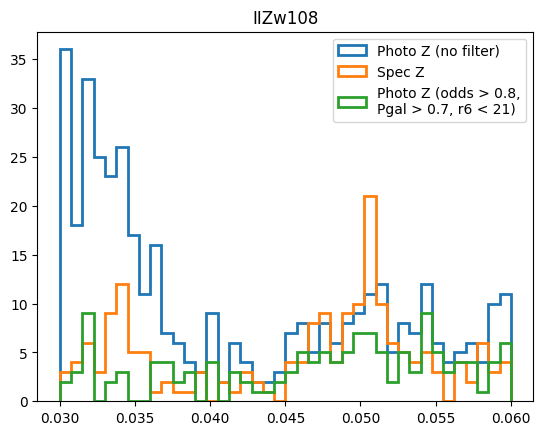

In [160]:
CLUSTER = 'IIZw108'

ranges = {
  'A119': (0.03, 0.06),
  'A147': (0.03, 0.06),
  'A168': (0.03, 0.06),
  'A194': (0.005, 0.035),
  'A2457': (0.045, 0.075),
  'IIZw108': (0.03, 0.06)
}

df = pd.read_csv(f'cluster_{CLUSTER}_spec.csv')

# df_xmatch[df_xmatch['z'].between(0.03, 0.06)]['z'].hist(bins=40)
# df_xmatch[df_xmatch['z'].between(0.03, 0.06)]['zml'].hist(bins=40)

zml_filter = (df['r_aper_6'] < 21) & (df['PROB_GAL'] > 0.8) & (df['odds'] > 0.7)

plt.hist(df['zml'], bins=40, range=ranges[CLUSTER], label='Photo Z (no filter)', histtype='step', linewidth=2)
plt.hist(df['z'], bins=40, range=ranges[CLUSTER], label='Spec Z', histtype='step', linewidth=2)
plt.hist(df[zml_filter]['zml'], bins=40, range=ranges[CLUSTER], label='Photo Z (odds > 0.8,\nPgal > 0.7, r6 < 21)', histtype='step', linewidth=2)
plt.title(CLUSTER)
plt.legend()
plt.savefig(f'{CLUSTER}_hist_f.png')
# plt.show()

# plt.hist(df_xmatch[df_xmatch['z'].between(0.045, 0.075)]['r_auto'], bins=30, range=(10, 25))
# plt.show()